# List for storing scaled model results

In [2]:
all_model_metrics_scaled = []

#SARIMAX LAG 1 (Scaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1093

--- Scaling Data (Fit on Train, Transform Both) ---
Data scaled. Mean of X_train is approx 0, Std is approx 1.

Building SARIMAX(0, 1, 1)x(1, 0, 0, 7) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                     SARIMAX Results                                     
Dep. Variable:                      Target_AQI_t   No. Observations:                  874
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -928.081
Date:                           Fri, 09 Jan 2026   AIC                           1868.162
Time:                                   10:33:13   BIC                           1896.732
Sample:                               01-02-2022   HQIC                          1879.097
                                    - 05-24-2024                                         
Covariance Type:                             opg                           

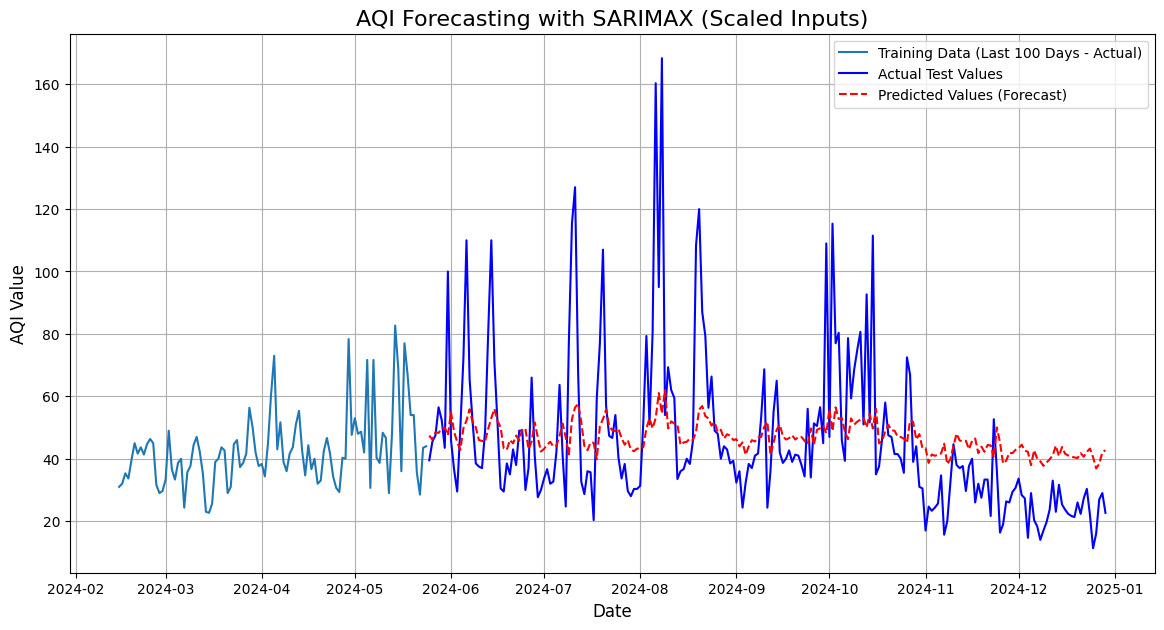

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler  # <--- IMPORT ADDED
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# Initialize a list to store metrics (assuming this exists in your wider workflow)
all_model_metrics = []

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG1_Ozone_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_Ozone'

    # Prepare Date index
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True)

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    y = df_clean[target_col].rename("Target_AQI_t")
    X = df_clean[[exog_col]].shift(1).rename(columns={exog_col: "Ozone_t_minus_1"})

    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["Ozone_t_minus_1"]]

    print(f"Aligned data points: {len(y_aligned)}")

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    # Raw splits (we keep y_test unscaled for final evaluation comparison)
    y_train_raw, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train_raw, X_test_raw = X_aligned[0:train_size], X_aligned[train_size:]

    # -------------------------------------------------------------------
    # 2b. SCALING (New Section)
    # -------------------------------------------------------------------
    print("\n--- Scaling Data (Fit on Train, Transform Both) ---")

    # Initialize Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 1. Scale X (Exogenous)
    # Fit on Train
    X_train_scaled_vals = scaler_X.fit_transform(X_train_raw)
    # Transform Test
    X_test_scaled_vals = scaler_X.transform(X_test_raw)

    # Re-attach the date index (SARIMAX needs the index)
    X_train = pd.DataFrame(X_train_scaled_vals, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test = pd.DataFrame(X_test_scaled_vals, index=X_test_raw.index, columns=X_test_raw.columns)

    # 2. Scale y (Target)
    # Reshape is needed because scaler expects 2D array, but y is a Series
    y_train_scaled_vals = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))

    # Re-attach index and flatten back to 1D array for SARIMAX
    y_train = pd.Series(y_train_scaled_vals.flatten(), index=y_train_raw.index, name="Target_AQI_t")

    print("Data scaled. Mean of X_train is approx 0, Std is approx 1.")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(0, 1, 1)x(1, 0, 0, 7) model...")

    # Note: We are passing the SCALED y_train and SCALED X_train
    model = sm.tsa.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(1, 1, 1),
        seasonal_order=(1, 0, 1, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # Predict using SCALED X_test
    # The output `predictions_scaled` will be in the scaled units (Z-scores)
    predictions_scaled = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test
    )

    # --- INVERSE TRANSFORM ---
    # We must convert the predicted Z-scores back to AQI values
    pred_reshaped = predictions_scaled.values.reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(pred_reshaped)

    # Convert back to Pandas Series for plotting/metrics
    predictions_series = pd.Series(predictions_original.flatten(), index=y_test.index)

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    # We compare predictions_series (unscaled) vs y_test (unscaled)
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

     # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_test - predictions_series)**2)

    # Calculate the variance (power) of the true values
    # The mean is calculated implicitly here, you can also use np.var(y_true)
    variance_true = np.mean((y_test - np.mean(predictions_series))**2)

    nmse = mse / variance_true

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
        'Model': 'LAG_1_Model',
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'NMSE': nmse
    }
    all_model_metrics_scaled.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    # Plot original y_train (unscaled) for context, or scaled if you prefer
    plt.plot(y_train_raw.tail(100), label='Training Data (Last 100 Days - Actual)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Scaled Inputs)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    print("\nPlot displayed.")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

#SARIMAX LAG 7 (Scaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1081

--- Scaling Data (Fit on Train, Transform Both) ---
Data scaled. Mean of X_train is approx 0, Std is approx 1.

Building SARIMAX(0, 1, 1)x(1, 0, 0, 7) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                     SARIMAX Results                                      
Dep. Variable:                       Target_AQI_t   No. Observations:                  864
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 7)   Log Likelihood                -966.006
Date:                            Fri, 09 Jan 2026   AIC                           1940.013
Time:                                    10:36:39   BIC                           1959.022
Sample:                                01-08-2022   HQIC                          1947.292
                                     - 05-20-2024                                         
Covariance Type:                              opg                   

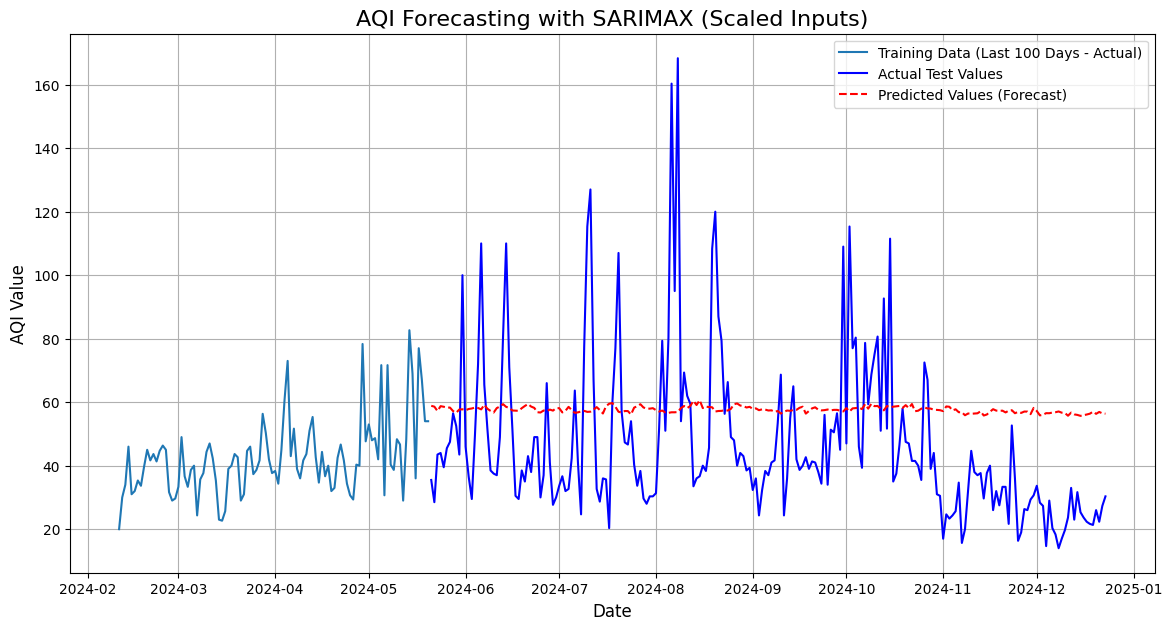

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler  # <--- IMPORT ADDED
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# Initialize a list to store metrics (assuming this exists in your wider workflow)
all_model_metrics = []

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG7_Ozone_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_Ozone'

    # Prepare Date index
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True)

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    y = df_clean[target_col].rename("Target_AQI_t")
    X = df_clean[[exog_col]].shift(7).rename(columns={exog_col: "Ozone_t_minus_7"})

    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["Ozone_t_minus_7"]]

    print(f"Aligned data points: {len(y_aligned)}")

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    # Raw splits (we keep y_test unscaled for final evaluation comparison)
    y_train_raw, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train_raw, X_test_raw = X_aligned[0:train_size], X_aligned[train_size:]

    # -------------------------------------------------------------------
    # 2b. SCALING (New Section)
    # -------------------------------------------------------------------
    print("\n--- Scaling Data (Fit on Train, Transform Both) ---")

    # Initialize Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 1. Scale X (Exogenous)
    # Fit on Train
    X_train_scaled_vals = scaler_X.fit_transform(X_train_raw)
    # Transform Test
    X_test_scaled_vals = scaler_X.transform(X_test_raw)

    # Re-attach the date index (SARIMAX needs the index)
    X_train = pd.DataFrame(X_train_scaled_vals, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test = pd.DataFrame(X_test_scaled_vals, index=X_test_raw.index, columns=X_test_raw.columns)

    # 2. Scale y (Target)
    # Reshape is needed because scaler expects 2D array, but y is a Series
    y_train_scaled_vals = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))

    # Re-attach index and flatten back to 1D array for SARIMAX
    y_train = pd.Series(y_train_scaled_vals.flatten(), index=y_train_raw.index, name="Target_AQI_t")

    print("Data scaled. Mean of X_train is approx 0, Std is approx 1.")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(0, 1, 1)x(1, 0, 0, 7) model...")

    # Note: We are passing the SCALED y_train and SCALED X_train
    model = sm.tsa.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 0, 7),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # Predict using SCALED X_test
    # The output `predictions_scaled` will be in the scaled units (Z-scores)
    predictions_scaled = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test
    )

    # --- INVERSE TRANSFORM ---
    # We must convert the predicted Z-scores back to AQI values
    pred_reshaped = predictions_scaled.values.reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(pred_reshaped)

    # Convert back to Pandas Series for plotting/metrics
    predictions_series = pd.Series(predictions_original.flatten(), index=y_test.index)

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    # We compare predictions_series (unscaled) vs y_test (unscaled)
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

     # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_test - predictions_series)**2)

    # Calculate the variance (power) of the true values
    # The mean is calculated implicitly here, you can also use np.var(y_true)
    variance_true = np.mean((y_test - np.mean(predictions_series))**2)

    nmse = mse / variance_true

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
        'Model': 'LAG_7_Model',
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'NMSE': nmse
    }
    all_model_metrics_scaled.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    # Plot original y_train (unscaled) for context, or scaled if you prefer
    plt.plot(y_train_raw.tail(100), label='Training Data (Last 100 Days - Actual)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Scaled Inputs)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    print("\nPlot displayed.")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

#SARIMAX LAG 14 (Scaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1067

--- Scaling Data (Fit on Train, Transform Both) ---
Data scaled. Mean of X_train is approx 0, Std is approx 1.

Building SARIMAX(0, 1, 1)x(1, 0, 0, 14) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                      SARIMAX Results                                      
Dep. Variable:                        Target_AQI_t   No. Observations:                  853
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 14)   Log Likelihood                -951.806
Date:                             Fri, 09 Jan 2026   AIC                           1911.613
Time:                                     10:38:03   BIC                           1930.537
Sample:                                 01-15-2022   HQIC                          1918.866
                                      - 05-16-2024                                         
Covariance Type:                               opg          

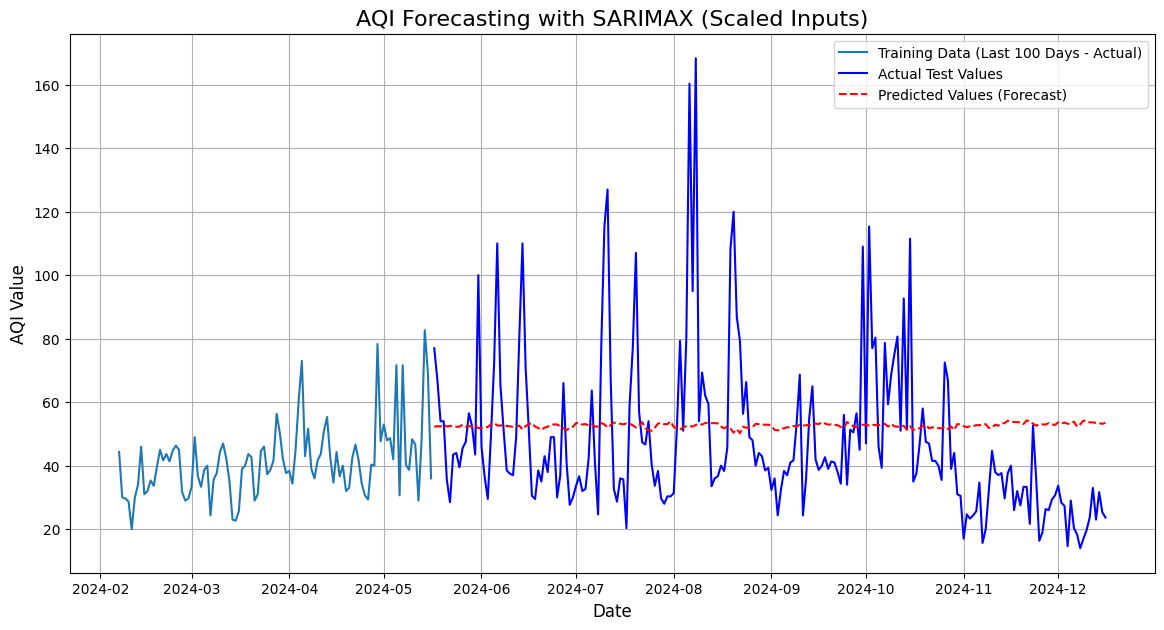

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler  # <--- IMPORT ADDED
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# Initialize a list to store metrics (assuming this exists in your wider workflow)
all_model_metrics = []

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG14_Ozone_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_Ozone'

    # Prepare Date index
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True)

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    y = df_clean[target_col].rename("Target_AQI_t")
    X = df_clean[[exog_col]].shift(14).rename(columns={exog_col: "Ozone_t_minus_14"})

    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["Ozone_t_minus_14"]]

    print(f"Aligned data points: {len(y_aligned)}")

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    # Raw splits (we keep y_test unscaled for final evaluation comparison)
    y_train_raw, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train_raw, X_test_raw = X_aligned[0:train_size], X_aligned[train_size:]

    # -------------------------------------------------------------------
    # 2b. SCALING (New Section)
    # -------------------------------------------------------------------
    print("\n--- Scaling Data (Fit on Train, Transform Both) ---")

    # Initialize Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 1. Scale X (Exogenous)
    # Fit on Train
    X_train_scaled_vals = scaler_X.fit_transform(X_train_raw)
    # Transform Test
    X_test_scaled_vals = scaler_X.transform(X_test_raw)

    # Re-attach the date index (SARIMAX needs the index)
    X_train = pd.DataFrame(X_train_scaled_vals, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test = pd.DataFrame(X_test_scaled_vals, index=X_test_raw.index, columns=X_test_raw.columns)

    # 2. Scale y (Target)
    # Reshape is needed because scaler expects 2D array, but y is a Series
    y_train_scaled_vals = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))

    # Re-attach index and flatten back to 1D array for SARIMAX
    y_train = pd.Series(y_train_scaled_vals.flatten(), index=y_train_raw.index, name="Target_AQI_t")

    print("Data scaled. Mean of X_train is approx 0, Std is approx 1.")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(0, 1, 1)x(1, 0, 0, 14) model...")

    # Note: We are passing the SCALED y_train and SCALED X_train
    model = sm.tsa.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 0, 14),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # Predict using SCALED X_test
    # The output `predictions_scaled` will be in the scaled units (Z-scores)
    predictions_scaled = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test
    )

    # --- INVERSE TRANSFORM ---
    # We must convert the predicted Z-scores back to AQI values
    pred_reshaped = predictions_scaled.values.reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(pred_reshaped)

    # Convert back to Pandas Series for plotting/metrics
    predictions_series = pd.Series(predictions_original.flatten(), index=y_test.index)

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    # We compare predictions_series (unscaled) vs y_test (unscaled)
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)

     # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_test - predictions_series)**2)

    # Calculate the variance (power) of the true values
    # The mean is calculated implicitly here, you can also use np.var(y_true)
    variance_true = np.mean((y_test - np.mean(predictions_series))**2)

    nmse = mse / variance_true

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")

    metrics_data = {
        'Model': 'LAG_14_Model',
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'NMSE': nmse
    }
    all_model_metrics_scaled.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    # Plot original y_train (unscaled) for context, or scaled if you prefer
    plt.plot(y_train_raw.tail(100), label='Training Data (Last 100 Days - Actual)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Scaled Inputs)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    print("\nPlot displayed.")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

#SARIMAX LAG 30 (Scaled)


--- Feature Engineering: Creating Lagged Predictor ---
Aligned data points: 1035

--- Scaling Data (Fit on Train, Transform Both) ---
Data scaled. Mean of X_train is approx 0, Std is approx 1.

Building SARIMAX(0, 1, 1)x(1, 0, 0, 14) model...
Fitting the model...

--- SARIMAX Model Summary ---
                                      SARIMAX Results                                      
Dep. Variable:                        Target_AQI_t   No. Observations:                  828
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 30)   Log Likelihood                -907.560
Date:                             Fri, 09 Jan 2026   AIC                           1823.119
Time:                                     10:39:08   BIC                           1841.842
Sample:                                 01-31-2022   HQIC                          1830.313
                                      - 05-07-2024                                         
Covariance Type:                               opg          

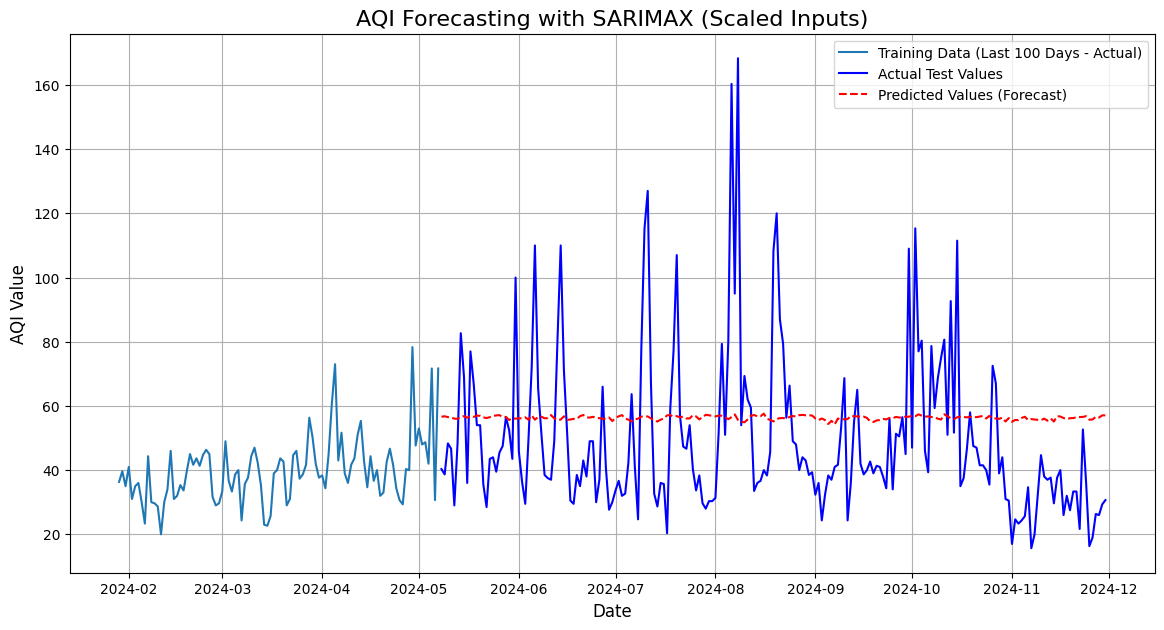

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler  # <--- IMPORT ADDED
import warnings

# Suppress common warnings from statsmodels
warnings.filterwarnings("ignore")

# Initialize a list to store metrics (assuming this exists in your wider workflow)
all_model_metrics = []

# -------------------------------------------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------------------------------------------
try:
    file_name = 'LAG30_Ozone_Combined_AQI_2022_2024.csv'
    df = pd.read_csv(file_name)

    # Define our column names
    date_col = 'DATE'
    target_col = 'Daily_AQI_Value'
    exog_col = 'Daily_Mean_Ozone'

    # Prepare Date index
    df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d', errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Select only the columns we will use
    df_clean = df[[target_col, exog_col]].copy()

    # Convert data columns to numbers
    df_clean[target_col] = pd.to_numeric(df_clean[target_col], errors='coerce')
    df_clean[exog_col] = pd.to_numeric(df_clean[exog_col], errors='coerce')

    # Set daily frequency ('D') and forward-fill missing values
    df_clean = df_clean.asfreq('D')
    df_clean.fillna(method='ffill', inplace=True)
    df_clean.dropna(inplace=True)

    # -------------------------------------------------------------------
    # 2. Define Target (y) and Lagged Exogenous (X)
    # -------------------------------------------------------------------
    print("\n--- Feature Engineering: Creating Lagged Predictor ---")

    y = df_clean[target_col].rename("Target_AQI_t")
    X = df_clean[[exog_col]].shift(30).rename(columns={exog_col: "Ozone_t_minus_30"})

    combined_df = pd.concat([y, X], axis=1)
    combined_df.dropna(inplace=True)

    y_aligned = combined_df["Target_AQI_t"]
    X_aligned = combined_df[["Ozone_t_minus_30"]]

    print(f"Aligned data points: {len(y_aligned)}")

    # Split data chronologically (80% train, 20% test)
    train_size = int(len(y_aligned) * 0.8)

    # Raw splits (we keep y_test unscaled for final evaluation comparison)
    y_train_raw, y_test = y_aligned[0:train_size], y_aligned[train_size:]
    X_train_raw, X_test_raw = X_aligned[0:train_size], X_aligned[train_size:]

    # -------------------------------------------------------------------
    # 2b. SCALING (New Section)
    # -------------------------------------------------------------------
    print("\n--- Scaling Data (Fit on Train, Transform Both) ---")

    # Initialize Scalers
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # 1. Scale X (Exogenous)
    # Fit on Train
    X_train_scaled_vals = scaler_X.fit_transform(X_train_raw)
    # Transform Test
    X_test_scaled_vals = scaler_X.transform(X_test_raw)

    # Re-attach the date index (SARIMAX needs the index)
    X_train = pd.DataFrame(X_train_scaled_vals, index=X_train_raw.index, columns=X_train_raw.columns)
    X_test = pd.DataFrame(X_test_scaled_vals, index=X_test_raw.index, columns=X_test_raw.columns)

    # 2. Scale y (Target)
    # Reshape is needed because scaler expects 2D array, but y is a Series
    y_train_scaled_vals = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))

    # Re-attach index and flatten back to 1D array for SARIMAX
    y_train = pd.Series(y_train_scaled_vals.flatten(), index=y_train_raw.index, name="Target_AQI_t")

    print("Data scaled. Mean of X_train is approx 0, Std is approx 1.")

    # -------------------------------------------------------------------
    # 3. Build and Train the SARIMAX Model
    # -------------------------------------------------------------------
    print("\nBuilding SARIMAX(0, 1, 1)x(1, 0, 0, 14) model...")

    # Note: We are passing the SCALED y_train and SCALED X_train
    model = sm.tsa.SARIMAX(
        endog=y_train,
        exog=X_train,
        order=(0, 1, 1),
        seasonal_order=(1, 0, 0, 30),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    print("Fitting the model...")
    sarimax_model = model.fit(disp=False)

    print("\n--- SARIMAX Model Summary ---")
    print(sarimax_model.summary())

    # -------------------------------------------------------------------
    # 4. Make Predictions on the Test Set
    # -------------------------------------------------------------------
    print("\nMaking predictions on the test set...")

    # Predict using SCALED X_test
    # The output `predictions_scaled` will be in the scaled units (Z-scores)
    predictions_scaled = sarimax_model.predict(
        start=y_test.index[0],
        end=y_test.index[-1],
        exog=X_test
    )

    # --- INVERSE TRANSFORM ---
    # We must convert the predicted Z-scores back to AQI values
    pred_reshaped = predictions_scaled.values.reshape(-1, 1)
    predictions_original = scaler_y.inverse_transform(pred_reshaped)

    # Convert back to Pandas Series for plotting/metrics
    predictions_series = pd.Series(predictions_original.flatten(), index=y_test.index)

    # -------------------------------------------------------------------
    # 5. Evaluate and Plot the Results
    # -------------------------------------------------------------------
    # We compare predictions_series (unscaled) vs y_test (unscaled)
    r2 = r2_score(y_test, predictions_series)
    rmse = np.sqrt(mean_squared_error(y_test, predictions_series))
    mae = mean_absolute_error(y_test, predictions_series)



    # Calculate Mean Squared Error (MSE)
    mse = np.mean((y_test - predictions_series)**2)

    # Calculate the variance (power) of the true values
    # The mean is calculated implicitly here, you can also use np.var(y_true)
    variance_true = np.mean((y_test - np.mean(predictions_series))**2)

    nmse = mse / variance_true

    print("\n--- Model Evaluation (One-Step-Ahead Forecast) ---")
    print(f"Test R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE):  {mae:.4f}")
    print(f"Test Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Normalized Mean Squared Error (NMSE): {nmse:.4f}")

    metrics_data = {
        'Model': 'LAG_30_Model',
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'NMSE': nmse
    }
    all_model_metrics_scaled.append(metrics_data)

    # Plot the results
    plt.figure(figsize=(14, 7))
    # Plot original y_train (unscaled) for context, or scaled if you prefer
    plt.plot(y_train_raw.tail(100), label='Training Data (Last 100 Days - Actual)')
    plt.plot(y_test, color='blue', label='Actual Test Values')
    plt.plot(predictions_series, color='red', linestyle='--', label='Predicted Values (Forecast)')
    plt.title('AQI Forecasting with SARIMAX (Scaled Inputs)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('AQI Value', fontsize=12)
    plt.legend()
    plt.grid(True)

    print("\nPlot displayed.")
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [7]:
# After all models are run, convert the list into a DataFrame
final_metrics_df = pd.DataFrame(all_model_metrics_scaled)

# Save the single, complete DataFrame to a file
# final_metrics_df.to_csv('all_model_metrics_comparison.csv', index=False)
# print("\nFinal metrics saved to 'all_model_metrics_comparison.csv'")

print("\n--- Final Model Comparison DataFrame ---")
final_metrics_df.head()


--- Final Model Comparison DataFrame ---


,Model,MAE,RMSE,R-squared,NMSE
0,LAG_1_Model,15.968507,22.619920,0.193222,0.806292
1,LAG_7_Model,22.733910,27.183953,-0.184785,0.994279
2,LAG_14_Model,19.810241,25.612877,-0.055324,1.015831
3,LAG_30_Model,20.388787,25.428412,-0.071369,0.997341
